In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Function for loading notMNIST Dataset
# Default Input File notMNIST.npz
# trainData and trainTarget are Images and Annotations For Training
# validData and validTarget are Images and Annotations For Validation
# testData and testTarget are Images and Annotations For Testing
def loadData(datafile = "notMNIST.npz"):
    with np.load(datafile) as data:
        Data, Target = data["images"].astype(np.float32), data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Custom Dataset class. 
class notMNIST(Dataset):
    def __init__(self, annotations, images, transform=None, target_transform=None):
        self.img_labels = annotations
        self.imgs = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#Define CNN
class CNN(nn.Module):
    # Initialization Function
    def __init__(self, drop_out_p = 0.0):
        super(CNN, self).__init__()
        # Define Layers
        # Layer 1: Convolution Layer (Input Channel 1, Output Channel 32, Kernel Size 4) -> ReLU -> Batch Normalization -> Max Pool (Kernel Size 2)
        # Layer 2: Convolution Layer (Input Channel 32, Output Channel 64, Kernel Size 4) -> ReLU -> Batch Normalization -> Max Pool (Kernel Size 2)
        # Layer 3: Flatten Operation -> Fully Connected Layer With Dropout Probability drop_out_p (1024 By 784) -> ReLU
        # Layer 4: Fully Connected Layer (784 By 10)
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 4)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p = drop_out_p)
        self.fc1 = nn.Linear(1024, 784)
        self.fc2 = nn.Linear(784, 10)


    # Define Forward Function
    def forward(self, x):
      # Define Forward Function
        activation1 = self.pool1(self.norm1(F.relu(self.conv1(x))))
        activation2 = self.pool2(self.norm2(F.relu(self.conv2(activation1))))
        flattened = torch.flatten(activation2, start_dim = 1)
        activation3 = F.relu(self.fc1(self.dropout(flattened)))
        output = self.fc2(self.dropout(activation3))
        return output

# Define FNN
class FNN(nn.Module):
    # Initialization Function
    def __init__(self, drop_out_p = 0.0):
        super(FNN, self).__init__()
        # Define Layer
        # Layer1: Flatten Operation -> Fully Connected Layer (784 By 10) -> ReLU
        # Layer2: Fully Connected Layer (10 By 10) -> ReLU
        # Layer3: Fully Connected Layer With Dropout Probability drop_out_p (10 By 10)
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.dropout = nn.Dropout(p = drop_out_p)

    # Define Forward Function
    def forward(self, x):
        # Define Forward Function
        flattened = torch.flatten(x, start_dim = 1)
        activation1 = F.relu(self.fc1(flattened))
        activation2 = F.relu(self.fc2(activation1))
        output = self.fc3(self.dropout(activation2))
        return output

# Commented out IPython magic to ensure Python compatibility.
# Compute accuracy
def get_accuracy(model, dataloader):
    # Variable Declaration
    model.eval()
    device = next(model.parameters()).device
    accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device) 

            # Return the accuracy
            output = model(images)
            correct += (torch.max(output, 1)[1].view(labels.size()).data == labels.data).sum()
            total += images.shape[0]

    # Calculate Final Accuracy And Return It
    accuracy = correct / total
    return accuracy

# Training Model
def train(model, device, learning_rate, weight_decay, train_loader, val_loader, test_loader, num_epochs = 50, verbose = False):
  # Define your cross entropy loss function here 
    # Use cross entropy loss
    criterion = torch.nn.CrossEntropyLoss()
    
    # Define your optimizer here
    # Use AdamW optimizer, set the weights, learning rate and weight decay argument.
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

    acc_hist = {'train':[], 'val':[], 'test': []}

    for epoch in range(num_epochs):
        model = model.train()
        ## training step
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)

            # Follow the step in the tutorial
            ## forward + backprop + loss
            ## update model params
            # Forward Propagation
            output = model(images)

            # Loss Calculation
            loss = criterion(output, labels)

            # Backward Propagation And Update Model Parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
        acc_hist['train'].append(get_accuracy(model, train_loader))
        acc_hist['val'].append(get_accuracy(model, val_loader))
        acc_hist['test'].append(get_accuracy(model, test_loader))
        
        if verbose:
            print('Epoch: %d | Train Accuracy: %.2f | Validation Accuracy: %.2f | Test Accuracy: %.2f' \
                %(epoch, acc_hist['train'][-1], acc_hist['val'][-1], acc_hist['test'][-1]))

    return model, acc_hist

# Input
# "CNN" = Convolutional Neural Network
# "FNN" = Fully Connected Neural Network
# learning_rate, weight_decay, dropout_rate are scalars of type float
# num_epochs is an integer that specifies number of times model will train through the whole training set
# verbose is a boolean, verbose = True -> Print Training Process, verbose = False -> Print Nothing
# Output
# model is a torch.nn.Module of trained model
# acc_hist is a dictionary that contains the accuracy on training, validation and test sets at each epoch
def experiment(model_type = 'CNN', learning_rate = 0.0001, dropout_rate = 0.5, weight_decay = 0.01, num_epochs = 50, verbose = False):
    # Use GPU if it is available.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Inpute Batch size:
    BATCH_SIZE = 32

    # Convert images to tensor
    transform = transforms.Compose(
        [transforms.ToTensor()])

    # Get train, validation and test data loader.
    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

    train_data = notMNIST(trainTarget, trainData, transform=transform)
    val_data = notMNIST(validTarget, validData, transform=transform)
    test_data = notMNIST(testTarget, testData, transform=transform)


    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # Specify which model to use
    if model_type == 'CNN':
        model = CNN(dropout_rate)
    elif model_type == 'FNN':
        model = FNN(dropout_rate)

    
    # Loading model into device
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    model, acc_hist = train(model, device, learning_rate, weight_decay, train_loader, val_loader, test_loader, num_epochs=num_epochs, verbose=verbose)
    
    # Release the model from the GPU (else the memory wont hold up)
    model.cpu()

    return model, acc_hist

# Plot Result
def plot(acc_hist):
    # Extract Training Accuracy
    training_accuracy = []
    for acc in acc_hist['train']:
        training_accuracy.append(acc.item())

    # Extract Validation Accuracy
    validation_accuracy = []
    for acc in acc_hist['val']:
        validation_accuracy.append(acc.item())

    # Extract Testing Accuracy
    testing_accuracy = []
    for acc in acc_hist['test']:
        testing_accuracy.append(acc.item())

    # Plot Training Accuracy
    plt.title("Training Accuracy Curve")
    plt.plot(training_accuracy, label = "Train", linewidth = 2.0)
    plt.xlabel("Epochs")
    plt.ylabel("Trainig Accuracy")
    plt.show()

    # Plot Validation Accuracy
    plt.title("Validation Accuracy Curve")
    plt.plot(validation_accuracy, label = "Validation", linewidth = 2.0)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()

    # Plot Testing Accuracy
    plt.title("Testing Accuracy Curve")
    plt.plot(testing_accuracy, label = "Testing", linewidth = 2.0)
    plt.xlabel("Epochs")
    plt.ylabel("Testing Accuracy")
    plt.show()

In [8]:
# Experiment 1
def compare_arch():
    # Train Model
    model_experiment_1_CNN, acc_hist_experiment_1_CNN = experiment(model_type = 'CNN', learning_rate = 0.0001, dropout_rate = 0.0, weight_decay = 0.0, num_epochs = 50, verbose = False)
    model_experiment_1_FNN, acc_hist_experiment_1_FNN = experiment(model_type = 'FNN', learning_rate = 0.0001, dropout_rate = 0.0, weight_decay = 0.0, num_epochs = 50, verbose = False)

    # Plot Result
    plot(acc_hist_experiment_1_CNN)
    plot(acc_hist_experiment_1_FNN)

    # Return Result
    return model_experiment_1_CNN, acc_hist_experiment_1_CNN, model_experiment_1_FNN, acc_hist_experiment_1_FNN

In [9]:
# Experiment 2
def compare_dropout():
    # Variable Declaration
    dropout_list = [0.5, 0.8, 0.95]
    model_list = []
    acc_hist_list = []

    # Train Model
    for dropout_rates in dropout_list:
        model, acc_hist = experiment(model_type = 'CNN', learning_rate = 0.0001, dropout_rate = dropout_rates, weight_decay = 0.0, num_epochs = 50, verbose = False)
        model_list.append(model)
        acc_hist_list.append(acc_hist)

    # Plot Result
    for acc_hist in acc_hist_list:
        plot(acc_hist)
      
    # Return Result
    return model_list, acc_hist_list

In [10]:
# Experiment 3
def compare_l2():
    # Variable Declaration
    weight_decay_list = [0.1, 1.0, 10.0]
    model_list = []
    acc_hist_list = []

    # Train Model
    for weight_decays in weight_decay_list:
        model, acc_hist = experiment(model_type = 'CNN', learning_rate = 0.0001, dropout_rate = 0.0, weight_decay = weight_decays, num_epochs = 50, verbose = False)
        model_list.append(model)
        acc_hist_list.append(acc_hist)

    # Plot Result
    for acc_hist in acc_hist_list:
        plot(acc_hist)

    # Return Result
    return model_list, acc_hist_list

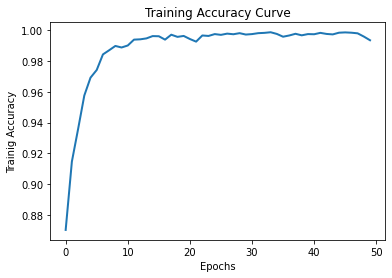

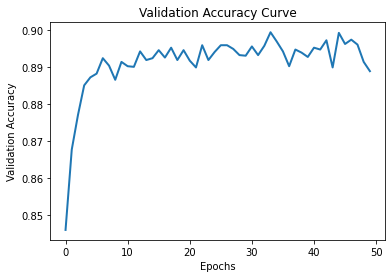

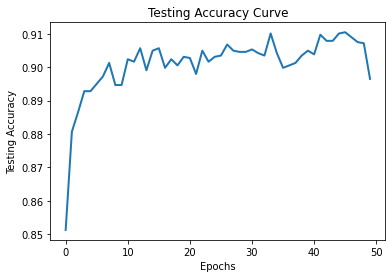

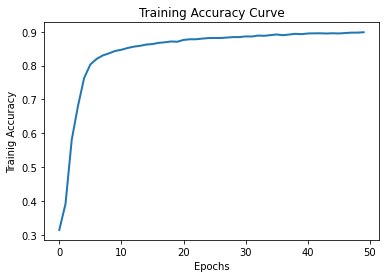

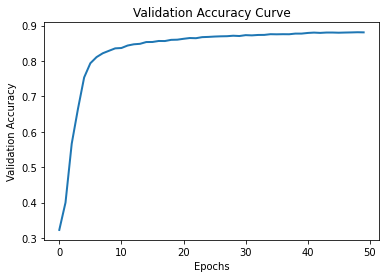

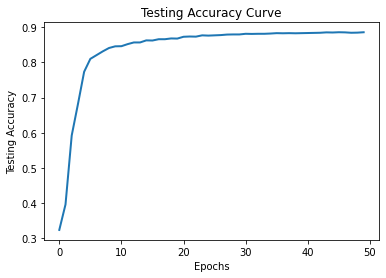

In [11]:
# Experiment 1
model_experiment_1_CNN, acc_hist_experiment_1_CNN, model_experiment_1_FNN, acc_hist_experiment_1_FNN = compare_arch()

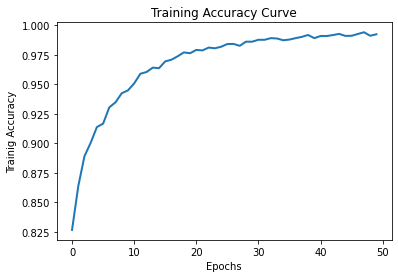

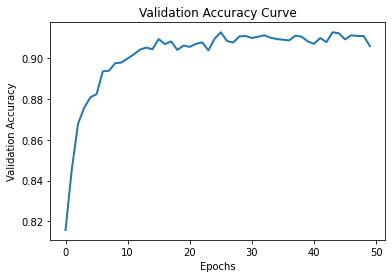

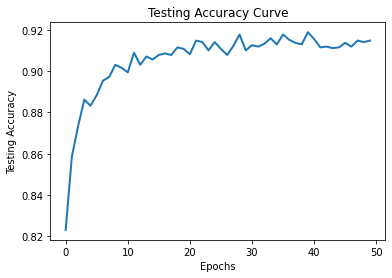

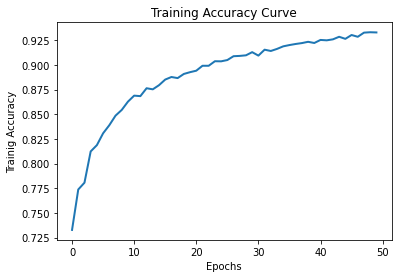

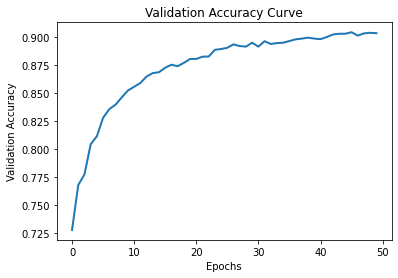

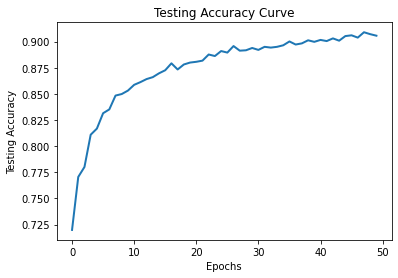

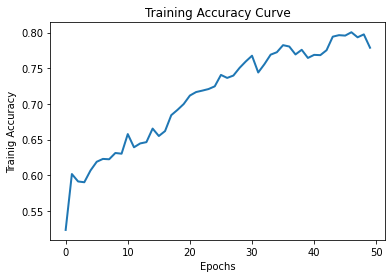

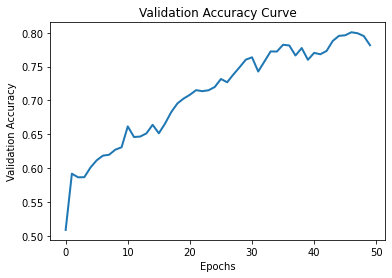

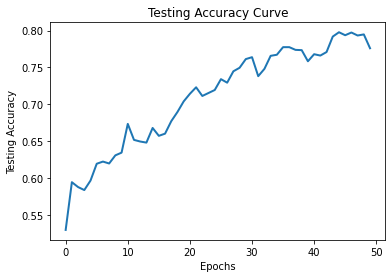

In [12]:
# Experiment 2
model_list, acc_hist_list = compare_dropout()

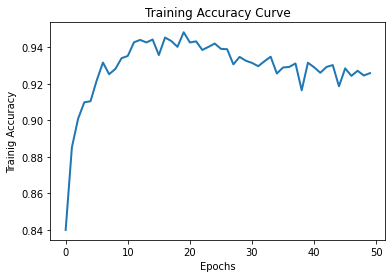

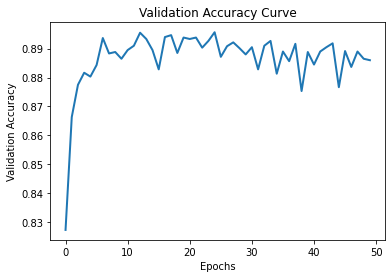

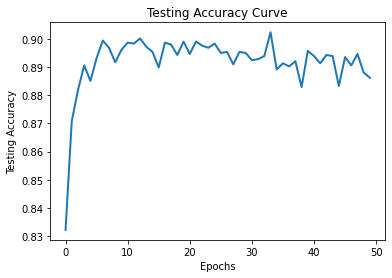

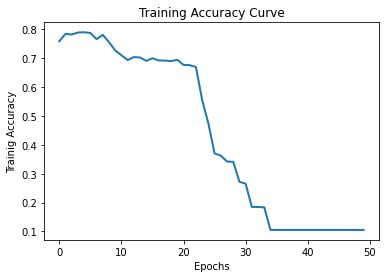

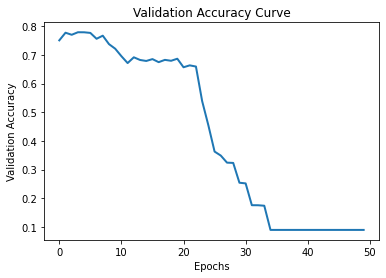

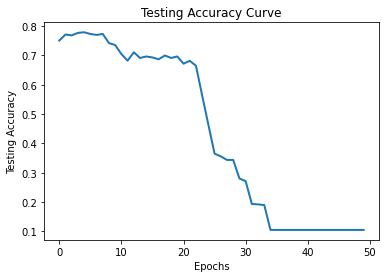

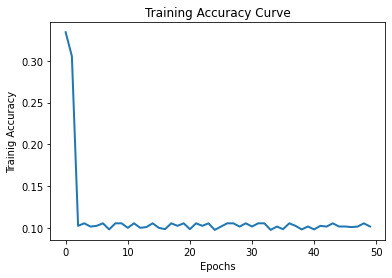

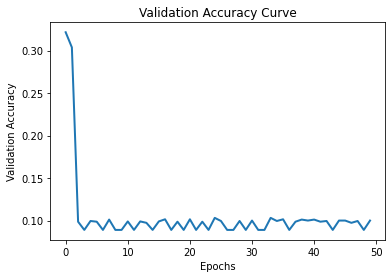

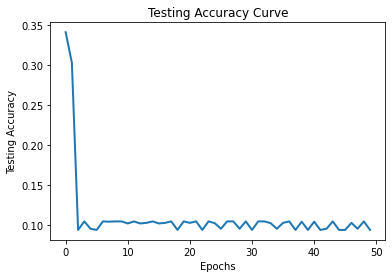

In [13]:
# Experiment 3
model_list, acc_hist_list = compare_l2()